# Data Wrangling

In [1]:
# import packages, get API KEY from .env file.
import os
from dotenv import load_dotenv
import requests
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

load_dotenv('.env')

API_KEY = os.getenv('NASDAQ_API_KEY')

In [2]:
# Call the Nasdaq API and get data in the form of a JSON.

url = 'https://data.nasdaq.com/api/v3/datasets/FSE/AFX_X?api_key=' + API_KEY
r = requests.get(url)
json_data = r.json()

In [3]:
#Create a list for opening prices from 2010 to 2017, and another list for the dates. Then convert to dataframe.

opening_prices = []
dates = []

for data in json_data['dataset']['data']:
    year = datetime.strptime(data[0],'%Y-%m-%d').year
    if year > 2009 and year < 2018:
        opening_prices.append(data[1])
        dates.append(data[0])

data_before_2018 = pd.DataFrame.from_dict({'date': dates, 'open': opening_prices}).set_index('date')
data_before_2018.index = pd.to_datetime(data_before_2018.index)
        
data_before_2018.head()

,open
date,
2017-12-29,51.76
2017-12-28,51.65
2017-12-27,51.45
2017-12-22,51.05
2017-12-21,51.16


Note that the starting point in time of our series is after 2008, because we don't want to include the disruption due to the 2008 financial crisis.

In [4]:
#Imputing missing data using both backward fill and forward fill
data_before_2018 = data_before_2018.fillna(method='backfill').fillna(method='ffill')
data_before_2018.head()

,open
date,
2017-12-29,51.76
2017-12-28,51.65
2017-12-27,51.45
2017-12-22,51.05
2017-12-21,51.16


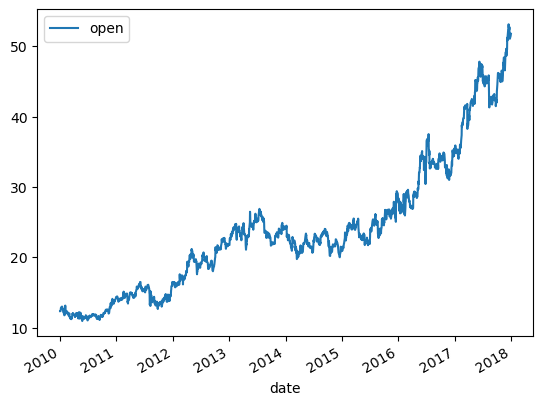

In [5]:
#Plotting the time series
data_before_2018.plot()
plt.show()

In [6]:
#Making sure that there is no remaining missing data
data_before_2018.isna().sum()

open    0
dtype: int64

In [7]:
#Summary statistics of the time series
data_before_2018.describe()

,open
count,2044.000000
mean,23.905303
std,9.554348
min,10.960000
25%,16.050000
50%,22.650000
75%,27.050000
max,53.110000


# EDA

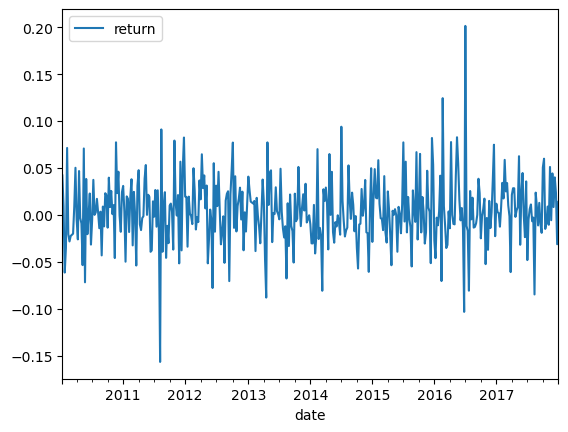

In [8]:
# Downsample the daily data to monthly data
weekly_data = data_before_2018.resample(rule='W').last()

# Compute the percentage change of prices
returns = weekly_data.pct_change().rename(columns={"open": "return"})
returns = returns[1:]

returns.plot()
plt.show()

In [9]:
# Compute and print the (lag-1) autocorrelation of returns
autocorrelation = returns['return'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.14


We see from the above that the autocorrelation is negative, which means the time series is mean-reversing. This is typical for stock prices. The value -0.14 sounds large, but is it statistically significant ? We test this by making a plot of the ACF function.

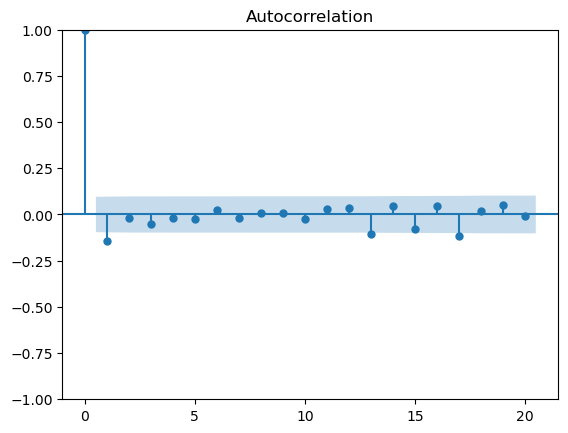

In [10]:
plot_acf(returns, alpha=0.05, lags=20)
plt.show()

We see that the lag-1 autocorrelation is outside of the 5-percent confidence interval (the region shaded in light blue). This means that if the true ACF were zero, the chance to observe the value -0.14 would be less than 5 percent. So the value -0.14 is statistically significant. Interestingly, the lag-13 and lag-17 autocorrelations also seem statistically significant, and the lag-15 autocorrelation is close to being statistically significant.

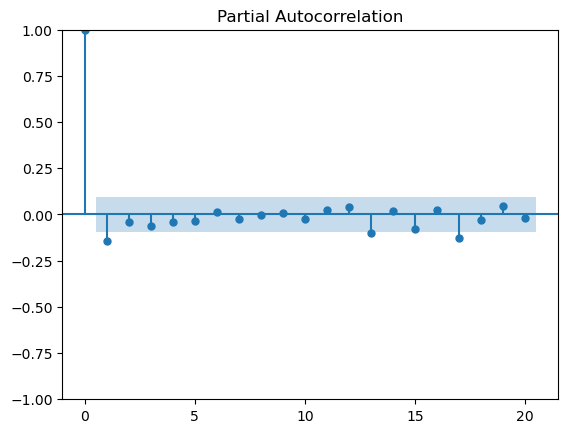

In [15]:
#It's also interesting to plot the partial autocorrelation function.
plot_pacf(returns, lags=20)
plt.show()

In [12]:
#Next, we use the Dickey-Fuller test to test if the stock price is a random walk.
adresults = adfuller(data_before_2018['open'])
print('The p-value of the AD test on opening prices is: ' + str(adresults[1]))

The p-value of the AD test on opening prices is: 0.0238175079707145


The p-value above is less than 5 percent. So we reject the null hypothesis that the stock price is a random walk.

Next, we do the KPSS test on the returns to see if the returns are a stationary time series:

In [13]:
kpss(returns['return'])

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.11021482525693849,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Because the p-value is 0.1, which is bigger than 0.05, we can accept the null hypothesis that the returns are a stationary time series.

In [16]:
#Finally, we save the prices and the returns as csv files.
data_before_2018.to_csv('p')

,open
date,
2017-12-29,51.76
2017-12-28,51.65
2017-12-27,51.45
2017-12-22,51.05
2017-12-21,51.16
...,...
2010-01-07,12.83
2010-01-06,12.75
2010-01-05,12.47
